In [1]:
import pandas as pd
import plotly.express as px
# ^^^ pyforest auto-imports - don't write above this line
import os
import codecs
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.precision', 10)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px

#for l2 normalization
import sklearn.preprocessing



import re
import spacy

#initiate spacy with english language
#nlp = spacy.load('en_core_web_sm')
import en_core_web_sm
nlp = en_core_web_sm.load()
from pattern.en import suggest
import nltk

#phrase modeling
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases , Phraser
import string
from nltk import pos_tag

# NLTK Stop words
from nltk.corpus import stopwords

from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize
from gensim.models.word2vec import Text8Corpus
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import gensim
from gensim import corpora
from gensim.corpora import Dictionary, MmCorpus

#clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#for creating wordcloud
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add('Microsoft')
stopwords.add('Teams')

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#import fasttext
import fasttext 
import sister

import umap
import hdbscan

# Import the necessaries libraries
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()


import plotly
from plotly import version
print (version)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

C:\Users\fulto\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  from ipykernel import kernelapp as app


<module 'plotly.version' from 'C:\\Users\\fulto\\anaconda3\\lib\\site-packages\\plotly\\version.py'>


In [2]:
os.chdir('C:\\Users\\fulto\\Desktop\\Driver Analysis\\Teams')

In [3]:
df = pd.read_csv('sas_teams_since_jan_2020.csv')
df2= pd.read_csv('sas_teams_web_since_Jan_2020.csv')

df = pd.concat([df, df2], axis = 0)

In [4]:
df.Feedback_Type.unique()

array(['Idea', 'Frown'], dtype=object)

In [5]:
def scrub_text(df, text_column, trigrams = False, lemmatize = False):
    
    '''
    
    This function takes a column of text and cleans it, while also performing phrase modeling on the column
    
    '''
    
    #get all reviews into list
    data = list(df[text_column].values)


    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
    data_words = list(sent_to_words(data))  
    
    # Build the bigram and trigram models
    #the min_count determines if the model ignores all words and bigrams with total collected count lower than this value.
    bigram = gensim.models.Phrases(data_words, min_count=1, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], min_count = 1, threshold=100)

    #get a sentence as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        stopwords.add('microsoft')
        stopwords.add('teams')
        return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]
    
#     lemmatizing produces an actual english word as a root as opposed to stemming which may not be a real word
    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    
    if trigrams == True:
   
        # Form trigrams
        data = make_trigrams(data_words)

        # Do lemmatization keeping only noun, adj, vb, adv
    if lemmatize == True:
        
        data = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
        data = lemmatization(data_words_bigrams, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    else:
        
        data = make_bigrams(data_words_nostops)
        
    #take all of the lemmatized and trigrammed reviews and dump them into a new column
    df['scrubbed_text'] = [x for x in data]
        
    #convert column of lists to strings
    df['scrubbed_text'] = df['scrubbed_text'].apply(', '.join)

    #remove commas from strings
    df['scrubbed_text'] = df['scrubbed_text'].str.replace(',','')

    return df

In [6]:
#scrub these out
wi = df[(df['Feedback_Type'] == 'Idea') & (df['Feedback_Platform'] == 'Windows Desktop')]
wf = df[(df['Feedback_Type'] == 'Frown') & (df['Feedback_Platform'] == 'Windows Desktop')]
webi = df[(df['Feedback_Type'] == 'Idea') & (df['Feedback_Platform'] == 'Web')]
webf = df[(df['Feedback_Type'] == 'Frown') & (df['Feedback_Platform'] == 'Web')]

In [7]:
wi = scrub_text(wi, 'Feedback_Verbatim')

In [8]:
wf = scrub_text(wf, 'Feedback_Verbatim')

In [9]:
webi = scrub_text(webi, 'Feedback_Verbatim')
webf = scrub_text(webf, 'Feedback_Verbatim')

In [10]:
wi.shape

(51372, 30)

In [11]:
wf.shape

(56646, 30)

In [12]:
webi.shape

(7692, 30)

In [13]:
webf.shape

(4039, 30)

In [34]:
def create_wordcloud(df):
    text = df.scrubbed_text.values
    wordcloud = WordCloud(width = 2650, height = 1650, background_color = 'black', stopwords = STOPWORDS).generate(str(text))
    fig = plt.figure(figsize = (13, 10), facecolor = 'k', edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show();

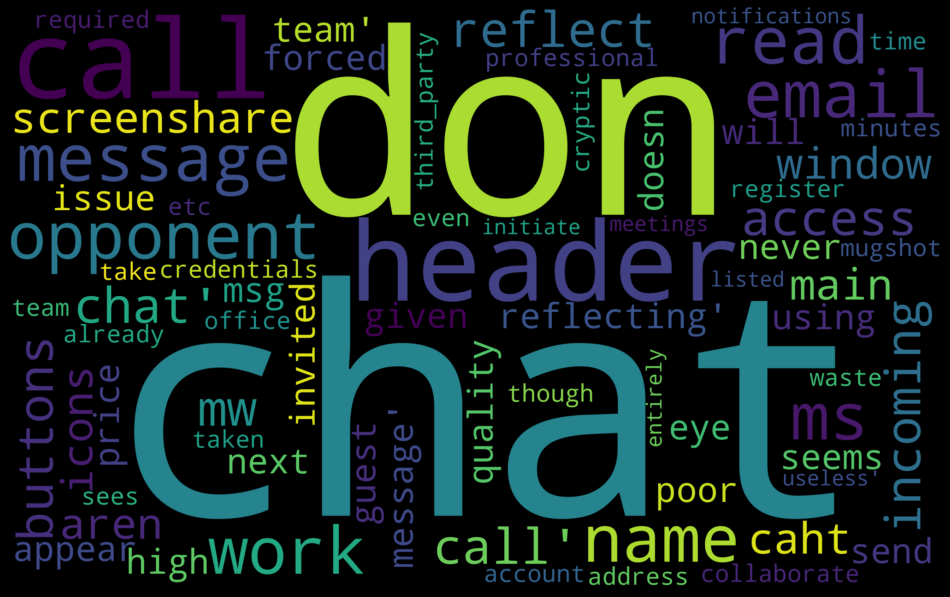

In [35]:
create_wordcloud(wi)

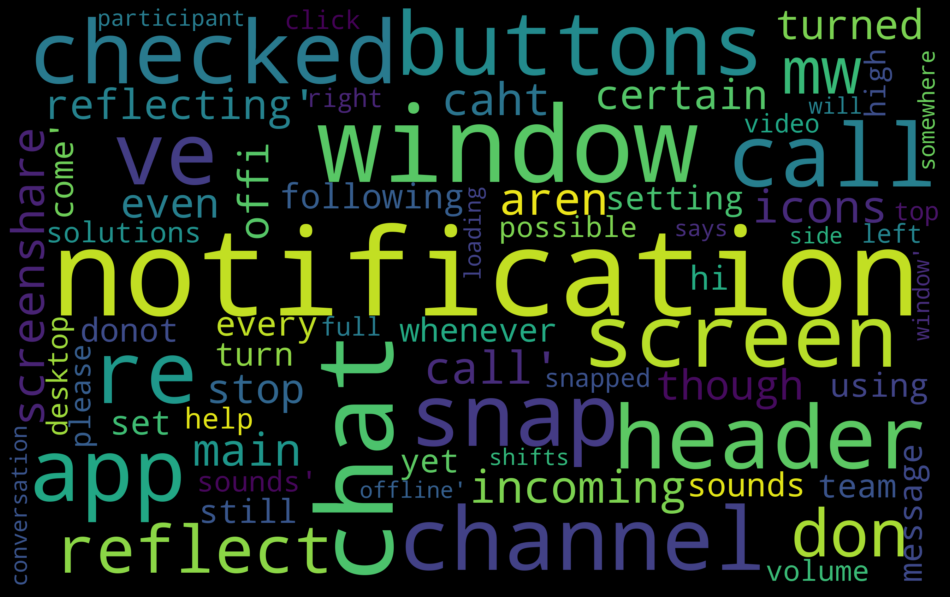

In [36]:
create_wordcloud(wf)

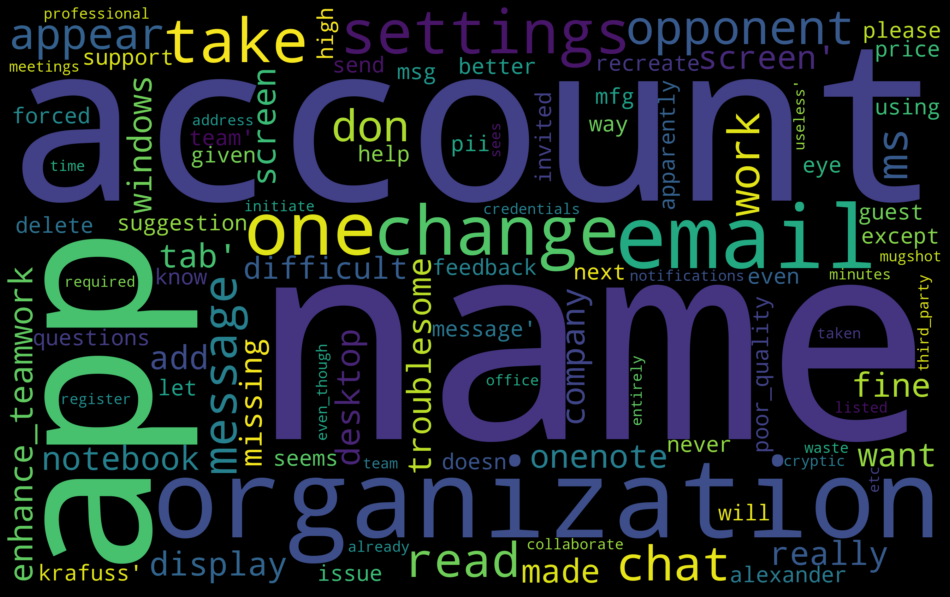

In [59]:
create_wordcloud(webi)

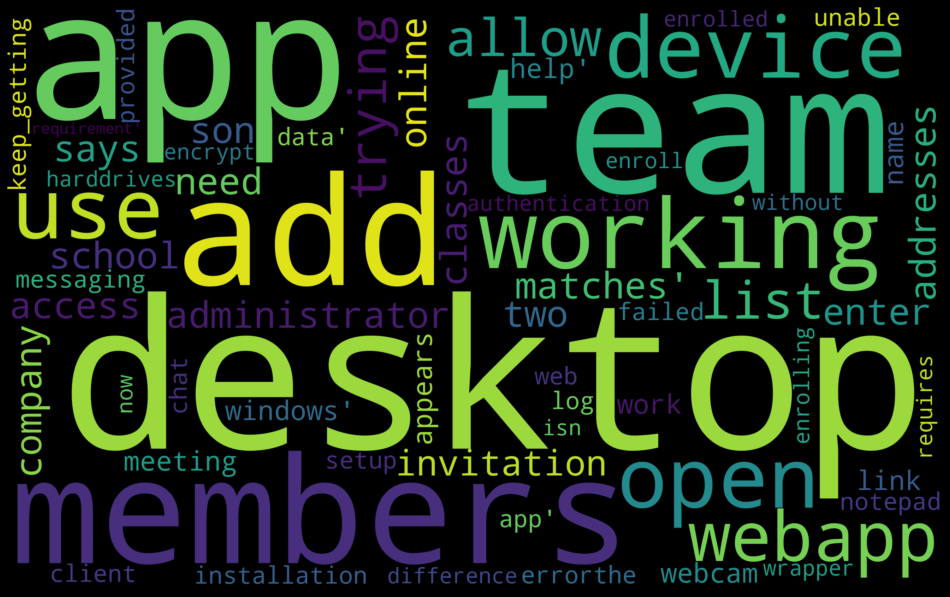

In [60]:
create_wordcloud(webf)

In [15]:
def create_vectors(df, export_csv = True):

    #create embeddings for each query
    bert_embedding = sister.BertEmbedding(lang="en")

    #using BERT to create embeddings
    vectors = [bert_embedding(sent) for sent in df.scrubbed_text]

    #convert to df
    verbatim_vectors = pd.DataFrame(vectors)

    #normalizing word vectors to improve similarity performance https://stats.stackexchange.com/questions/177905/should-i-normalize-word2vecs-word-vectors-before-using-them
    # research says that using the l2 norm improves model performance more than any other normalization method https://www.groundai.com/project/improving-bert-fine-tuning-wit
    #h-embedding-normalization/1
    #so we are using the l2 norm here for unit norm transformation
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
    normed_vectors = sklearn.preprocessing.normalize(verbatim_vectors, norm = 'l2', axis = 1)

    #make the actual queries the index of each embedding
    normed_vectors = pd.DataFrame(normed_vectors)
    normed_vectors.index = [x for x in df['Feedback_Verbatim']]
    
    if export_csv == True:
        
        if (df[df['Feedback_Platform'].str.contains('Web')].shape[0] > 0) & (df[df['Feedback_Type'] == 'Idea']):

            #send vectors to csv in case the kernel dies
            normed_vectors.to_csv(f'web_idea_vectors.csv')
        
        elif (df[df['Feedback_Platform'].str.contains('Windows Desktop')].shape[0] > 0) & (df[df['Feedback_Type'] == 'Idea']):
            
            normed_vectors.to_csv('windows_idea_vectors.csv')
            
        elif (df[df['Feedback_Platform'].str.contains('Web')].shape[0] > 0) & (df[df['Feedback_Type'] == 'Frown']):
            
            normed_vectors.to_csv('web_frown_vectors.csv')
            
        elif (df[df['Feedback_Platform'].str.contains('Windows Desktop')].shape[0] > 0) & (df[df['Feedback_Type'] == 'Frown']):
            
            normed_vectors.to_csv('windows_frown_vectors.csv')
            
    return normed_vectors

In [16]:
normed_wi_vecs = create_vectors(wi, export_csv = True)
normed_wf_vecs = create_vectors(wf, export_csv = True)
normed_webi_vecs = create_vectors(webi, export_csv = True)
normed_webf_vecs = create_vectors(webf, export_csv = True)

normed_wi_vecs.to_csv('normed_wi_vecs.csv')
normed_wf_vecs.to_csv('normed_wf_vecs.csv')
normed_webi_vecs.to_csv('normed_webi_vecs.csv')
normed_webf_vecs.to_csv('normed_webf_vecs.csv')

Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (852 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (954 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (852 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [ ]:
# reduce vectors, then cluster them -- https://umap-learn.readthedocs.io/en/latest/clustering.html
reducer = umap.UMAP(n_neighbors=30, n_components = 3, min_dist = 0)
reduced_wi_vectors = reducer.fit_transform(normed_wi_vecs)
reduced_wf_vectors = reducer.fit_transform(normed_wf_vecs)
reduced_webi_vectors = reducer.fit_transform(normed_webi_vecs)
reduced_webf_vectors = reducer.fit_transform(normed_webf_vecs)

In [ ]:
wi_cluster_labels = hdbscan.HDBSCAN(min_cluster_size=100, min_samples = 1, cluster_selection_method = 'leaf').fit_predict(reduced_wi_vectorr)